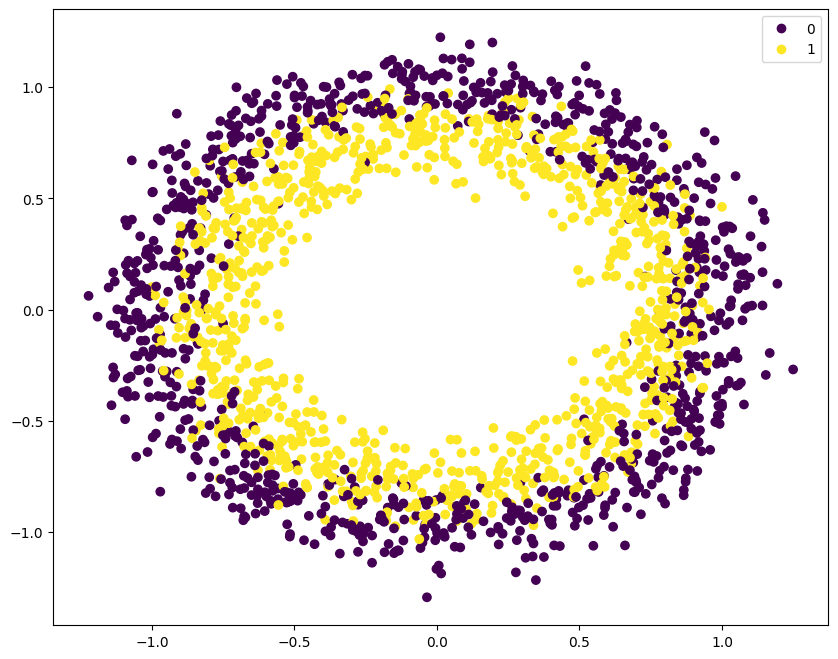

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

random_state = 0

x, y = make_circles(n_samples=2000, noise=0.1, random_state=random_state)
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)

plt.figure(figsize=(10,8))
scatter = plt.scatter(x[:, 0], x[:, 1], c=y)
plt.legend(*scatter.legend_elements(), loc="upper right")
plt.show()

In [3]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=[4] * 1, max_iter=2000, early_stopping=True, 
                    n_iter_no_change=100, validation_fraction=0.2,
                    solver='adam', activation="relu", random_state=random_state, 
                    learning_rate_init=0.001)
mlp.fit(train_x, train_y)

MLPClassifier(early_stopping=True, hidden_layer_sizes=[4], max_iter=2000,
              n_iter_no_change=100, random_state=0, validation_fraction=0.2)

In [5]:
mlp.coefs_

[array([[ 1.26330575,  0.81106997,  2.28835997,  0.66100558],
        [ 0.37596265,  0.36973942, -0.85882211,  2.02183899]]),
 array([[ 0.87355974],
        [ 1.89058246],
        [-1.89513973],
        [-2.56049663]])]

In [6]:
mlp.intercepts_

[array([ 1.47921924,  0.93827836, -0.02134388, -0.4247285 ]),
 array([-0.66509044])]

In [ ]:
# create matrix A for Activation Pattern (1,1,1,1)

In [12]:
A = mlp.coefs_[0].transpose()
A

array([[ 1.26330575,  0.37596265],
       [ 0.81106997,  0.36973942],
       [ 2.28835997, -0.85882211],
       [ 0.66100558,  2.02183899]])

In [ ]:
# create column vector b for Activation Pattern (1,1,1,1)

In [24]:
b = mlp.intercepts_[0][:,np.newaxis]
b.shape

(4, 1)

In [8]:
# compute H = [b - A] to represent system of inequalities,
# and use pycddlib to solve and find verticies of resultant polytope that satisfies inequalities

In [57]:
H = np.hstack((b,-A))

In [58]:
H

array([[ 1.47921924, -1.26330575, -0.37596265],
       [ 0.93827836, -0.81106997, -0.36973942],
       [-0.02134388, -2.28835997,  0.85882211],
       [-0.4247285 , -0.66100558, -2.02183899]])

In [5]:
pip install pycddlib

  Using cached pycddlib-2.1.6.tar.gz (159 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for pycddlib: filename=pycddlib-2.1.6-cp39-cp39-macosx_11_0_arm64.whl size=172972 sha256=d71015a1c3cf76b2a390988137db857a4670a8e6b498c9b7c60cb0aea3f81ed7
  Stored in directory: /Users/anupamchaudhauri/Library/Caches/pip/wheels/75/05/2b/2f1e5eb9c729261a2589816fdfb22e41680843248fea04d58e
Successfully built pycddlib

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Install (pip install pycddlib )

import cdd
mat = cdd.Matrix([[2,-1,-1,0],[0,1,0,0],[0,0,1,0]], number_type='fraction')
mat.rep_type = cdd.RepType.INEQUALITY
poly = cdd.Polyhedron(mat)
print(poly)


begin
 3 4 rational
 2 -1 -1 0
 0 1 0 0
 0 0 1 0
end


In [59]:
mat1 = cdd.Matrix(H, number_type = 'float')
mat1.rep_type = cdd.RepType.INEQUALITY
poly1 = cdd.Polyhedron(mat1)
print(poly1)

begin
 4 3 real
  1.479219237E+00 -1.263305752E+00 -3.759626534E-01
  9.382783590E-01 -8.110699743E-01 -3.697394215E-01
 -2.134388145E-02 -2.288359972E+00  8.588221063E-01
 -4.247284966E-01 -6.610055764E-01 -2.021838985E+00
end


In [60]:
gen = poly1.get_generators()
print(gen)

V-representation
begin
 3 3 real
  1 -7.853102538E-02 -1.843960145E-01
  0 -1 -2.664533150E+00
  0 -3.058732116E+00  1
end


In [43]:
gen[0]

(1.0, -0.1479403469539093)

In [44]:
gen[1]

(1.0, 2.5756688192058763)

In [61]:
np.matrix([[gen[i][j] for j in range(0,gen.col_size)] for i in range(0,gen.row_size)])

matrix([[ 1.        , -0.07853103, -0.18439601],
        [ 0.        , -1.        , -2.66453315],
        [ 0.        , -3.05873212,  1.        ]])